# A/B Testing Project

Imagine you are a company that advertises on television. Your advertising expenses are very high, and you believe some costs need to be reduced. The first thing that comes to mind is: Are the ads really working? Should I reduce them, and if so, what should I focus on reducing? Which time slot or hour would be better to cut back on?
These types of questions have always been on the minds of companies. In this project, I present an analysis that provides answers to these questions.

## OBJECTIVE
To check whether the advertisements are truly meaningful. 
If a reduction in advertisements is considered, comparing the high-cost prime time slot with other slots and evaluating its importance.

Our hypotheses:

**H<sub>0</sub>:* There is no significant difference between the effects of public service announcements (PSA) and company advertisements (ad).  
**H<sub>1</sub>:* There is a significant difference between the effects of public service announcements (PSA) and company advertisements (ad).

Tests were conducted with p-values less than 0.05 considered statistically significant.

# Data Dictionary
* user id: User ID (unique)
* test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
* converted: If a person bought the product then True, else is False
* total ads: Amount of ads seen by person
* most ads day: Day that the person saw the biggest amount of ads
* most ads hour: Hour of day that the person saw the biggest amount of ads



# Code

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.stats.api as sms
from scipy.stats import norm, boxcox, stats
from tqdm import tqdm
from math import ceil
import matplotlib.pyplot as plt

import warnings

# Tüm uyarıları gizle
warnings.filterwarnings("ignore")


In [3]:
marketing = pd.read_csv('marketing_AB2.csv')
marketing = marketing.drop('Unnamed: 0', axis=1)
marketing

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


## Exploratory Data Analysis

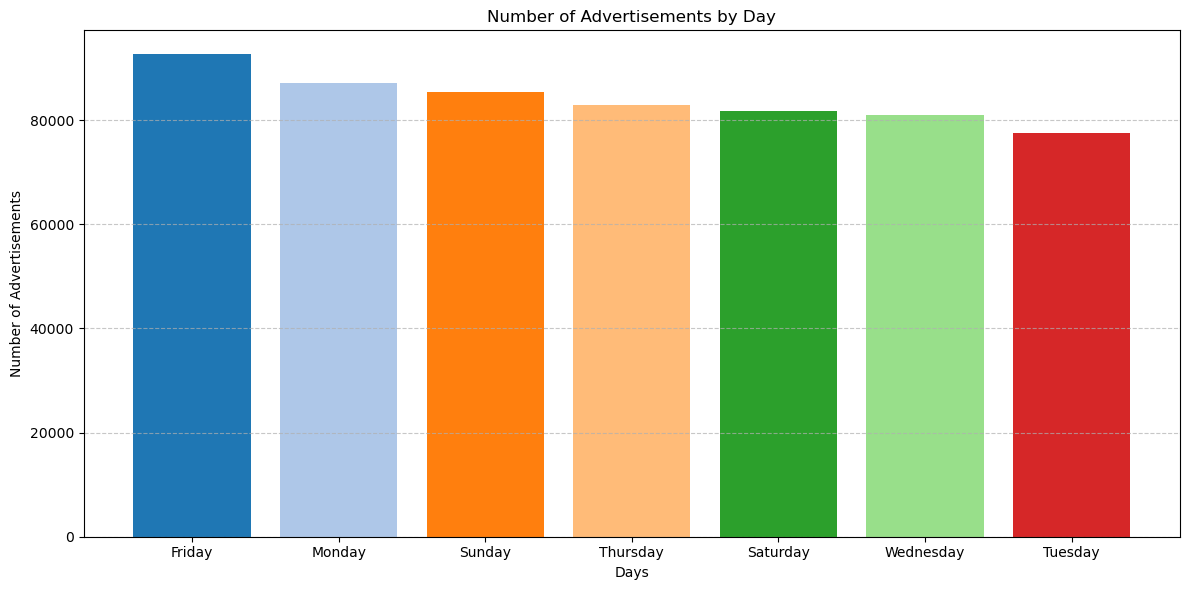

In [6]:
day_counts = marketing['most ads day'].value_counts()

plt.figure(figsize=(12, 6))
colors = plt.get_cmap('tab20')
plt.bar(day_counts.index, day_counts.values, color=colors(range(len(day_counts))))
plt.xlabel('Days')
plt.ylabel('Number of Advertisements')
plt.title('Number of Advertisements by Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


We can see that similar numbers of advertisements were shown on almost all days.

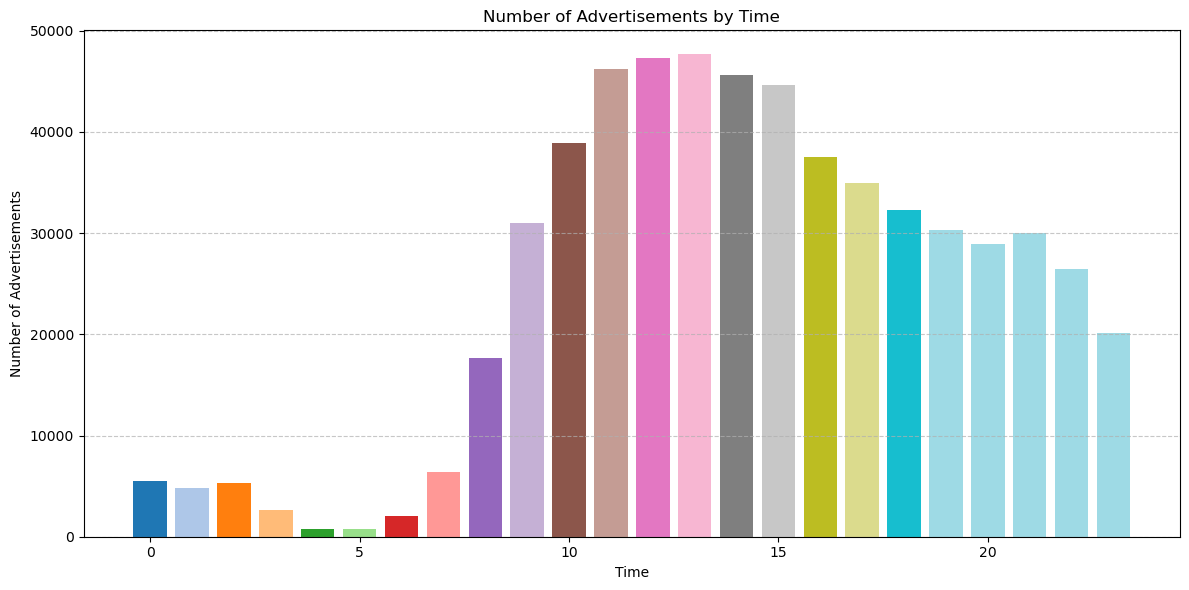

In [7]:
hour_counts = marketing['most ads hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
colors = plt.get_cmap('tab20')
plt.bar(hour_counts.index, hour_counts.values, color=colors(range(len(hour_counts))))
plt.xlabel('Time')
plt.ylabel('Number of Advertisements')
plt.title('Number of Advertisements by Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The situation is somewhat different during the hours. Particularly between 10 AM and 4 PM, there is a significant increase in the amount of advertisements, while we observe a plateau during prime time.








In [8]:
marketing.describe()

,user id,total ads,most ads hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


## Removal of outliers

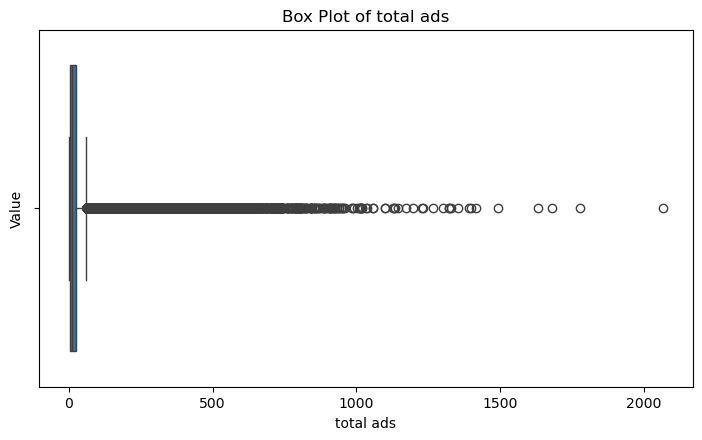

In [9]:

columns_to_plot = ['total ads']

df_selected = marketing[columns_to_plot]

num_cols = len(columns_to_plot)
rows = 4
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 15), constrained_layout=True)

for i, column in enumerate(columns_to_plot):
    row = i // cols
    col = i % cols
    sns.boxplot(x=df_selected[column], ax=axes[row, col])
    axes[row, col].set_title(f'Box Plot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Value')

for i in range(num_cols, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.show()


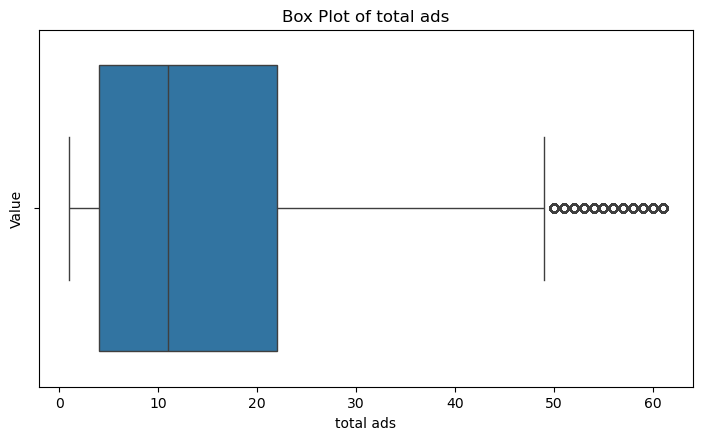

In [10]:
columns_to_plot = ['total ads']

# Aykırı değerleri çıkarma fonksiyonu
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aykırı değerleri çıkarma işlemi
for column in columns_to_plot:
    marketing = remove_outliers(marketing, column)

# Aykırı değerler çıkarıldıktan sonra boxplot çizdirme
marketing_selected = marketing[columns_to_plot]

num_cols = len(columns_to_plot)
rows = 4
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 15), constrained_layout=True)

for i, column in enumerate(columns_to_plot):
    row = i // cols
    col = i % cols
    sns.boxplot(x=marketing_selected[column], ax=axes[row, col])
    axes[row, col].set_title(f'Box Plot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Value')

# Boş grafik alanlarını temizleme
for i in range(num_cols, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.show()


It can be seen that a large portion of the data has been removed due to outliers.

In [11]:
marketing.shape

(536044, 6)

In [12]:
588101

588101

As a result of removing outliers from the raw data of 588,101, a total of 536,044 records remain, and 52,057 outlier records have been deleted.

In [13]:
ad_group_size = len(marketing[marketing['test group'] == 'ad'])
psa_group_size = len(marketing[marketing['test group'] == 'psa'])

print(f"Ad group size: {ad_group_size}")
print(f"PSA group size: {psa_group_size}")


Ad group size: 514716
PSA group size: 21328


## Data normalization

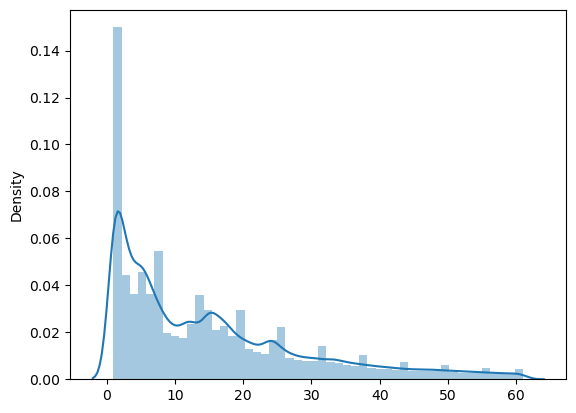

In [14]:
sp_transformed = sns.distplot(marketing[columns_to_plot])  

In [15]:
marketing[columns_to_plot]
# Skewness identification
columns_to_plot = ['total ads']

for column in columns_to_plot:
    skewness = marketing[column].skew()
    
    if skewness < -1.0:
        skewness_type = 'Highly Skewed (< -1.0): Data is highly asymmetrical with a long left tail.'
    elif skewness < -0.5:
        skewness_type = 'Moderate Negative Skew (-0.5 to -1.0): Data has a noticeable left tail, but not extreme.'
    elif skewness < 0.5:
        skewness_type = 'Fairly Symmetrical (-0.5 to 0.5): Data distribution is close to symmetrical, but might have slight deviations.'
    elif skewness < 1.0:
        skewness_type = 'Moderate Positive Skew (0.5 to 1.0): Data has a noticeable right tail, but not extreme.'
    else:
        skewness_type = 'Highly Skewed (> 1.0): Data is highly asymmetrical with a long right tail.'
    
    print(f"{column}: Skewness = {skewness:.2f}, Type = {skewness_type}")


total ads: Skewness = 1.21, Type = Highly Skewed (> 1.0): Data is highly asymmetrical with a long right tail.


As a result of the initial analysis, it was observed that the data is quite skewed and not suitable for statistical tests that assume a normal distribution. To make the data conform to a normal distribution, the square root transformation technique has been used below.

In [16]:
#Trying to sqrt transformation 

sqrt_transformed = np.sqrt(marketing["total ads"].replace(0, np.nan))


skewness = sqrt_transformed.skew()
    
if skewness < -1.0:
    skewness_type = 'Highly Skewed (< -1.0): Data is highly asymmetrical with a long left tail.'
elif skewness < -0.5:
    skewness_type = 'Moderate Negative Skew (-0.5 to -1.0): Data has a noticeable left tail, but not extreme.'
elif skewness < 0.5:
    skewness_type = 'Fairly Symmetrical (-0.5 to 0.5): Data distribution is close to symmetrical, but might have slight deviations.'
elif skewness < 1.0:
    skewness_type = 'Moderate Positive Skew (0.5 to 1.0): Data has a noticeable right tail, but not extreme.'
else:
    skewness_type = 'Highly Skewed (> 1.0): Data is highly asymmetrical with a long right tail.'
    
print(f"{column}: Skewness = {skewness:.2f}, Type = {skewness_type}")


total ads: Skewness = 0.43, Type = Fairly Symmetrical (-0.5 to 0.5): Data distribution is close to symmetrical, but might have slight deviations.


As seen, the data normalization process has achieved a nearly symmetric dataset.

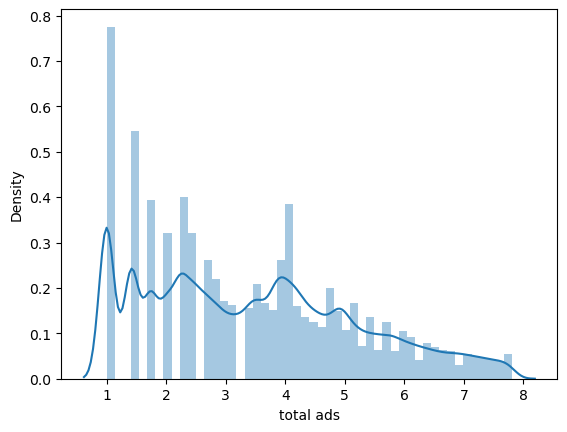

In [17]:
sp_transformed = sns.distplot(sqrt_transformed)  

In [18]:
marketing["total ads"] = sqrt_transformed

In [19]:
marketing

,user id,test group,converted,total ads,most ads day,most ads hour
2,1144181,ad,False,4.582576,Tuesday,18
7,1496843,ad,False,4.123106,Sunday,18
8,1448851,ad,False,4.582576,Tuesday,19
11,1637531,ad,False,6.855655,Wednesday,13
12,1081965,ad,False,7.810250,Tuesday,20
...,...,...,...,...,...,...
588096,1278437,ad,False,1.000000,Tuesday,23
588097,1327975,ad,False,1.000000,Tuesday,23
588098,1038442,ad,False,1.732051,Tuesday,23
588099,1496395,ad,False,1.000000,Tuesday,23


In [20]:
# check if some users appear multiple times
user_sess = marketing['user id'].value_counts()


In [21]:
user_sess

user id
1237779    1
1144181    1
1496843    1
1448851    1
1637531    1
          ..
1580543    1
1011246    1
905704     1
1067720    1
1459497    1
Name: count, Length: 536044, dtype: int64

In [23]:
filtered_users = user_sess[user_sess != 1]
print(filtered_users)


Series([], Name: count, dtype: int64)


In [24]:
marketing

,user id,test group,converted,total ads,most ads day,most ads hour
2,1144181,ad,False,4.582576,Tuesday,18
7,1496843,ad,False,4.123106,Sunday,18
8,1448851,ad,False,4.582576,Tuesday,19
11,1637531,ad,False,6.855655,Wednesday,13
12,1081965,ad,False,7.810250,Tuesday,20
...,...,...,...,...,...,...
588096,1278437,ad,False,1.000000,Tuesday,23
588097,1327975,ad,False,1.000000,Tuesday,23
588098,1038442,ad,False,1.732051,Tuesday,23
588099,1496395,ad,False,1.000000,Tuesday,23


In [25]:
ad_group_size = len(marketing[marketing['test group'] == 'ad'])
psa_group_size = len(marketing[marketing['test group'] == 'psa'])

print(f"Ad group size: {ad_group_size}")
print(f"PSA group size: {psa_group_size}")


Ad group size: 514716
PSA group size: 21328


In [26]:
effect = sms.proportion_effectsize(0.1, 0.15)

sample_size = sms.NormalIndPower().solve_power(
    effect,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)

sample_size = ceil(sample_size)

sample_size

681

In [27]:
# The treatment and control samples
trt = marketing[marketing['test group'] == 'ad'].sample(n=sample_size, random_state=1)

con = marketing[marketing['test group'] == 'psa'].sample(n=sample_size, random_state=1)

# Combining into one dataframe and resetting the indices
marketing = pd.concat([con, trt], axis=0)
marketing.reset_index(drop=True, inplace=True)



In [28]:
marketing.head(5)


,user id,test group,converted,total ads,most ads day,most ads hour
0,914789,psa,False,2.828427,Sunday,10
1,920984,psa,False,2.449490,Sunday,15
2,916207,psa,False,6.782330,Saturday,20
3,906506,psa,False,1.732051,Friday,21
4,903325,psa,False,1.000000,Friday,14


In [29]:
marketing.tail(5)


,user id,test group,converted,total ads,most ads day,most ads hour
1357,1108858,ad,True,6.164414,Wednesday,12
1358,1400958,ad,False,4.795832,Tuesday,8
1359,1243710,ad,False,3.316625,Tuesday,15
1360,1619131,ad,False,1.414214,Tuesday,10
1361,1340399,ad,False,2.000000,Tuesday,22


In [30]:
converted_con = marketing[marketing['test group'] == 'ad']['converted']

converted_trt = marketing[marketing['test group'] == 'psa']['converted']

n_control = converted_con.count()

n_treatment = converted_trt.count()

num_converted = [converted_con.sum(), converted_trt.sum()]

nobs = [n_control, n_treatment]

# p-value?
z_stat, pval = sms.proportions_ztest(num_converted, nobs=nobs)

pval


np.float64(0.03759017968909186)

### Advertisement values between 20 PM and 23 PM (prime time)

In [31]:
marketing = pd.read_csv('marketing_AB2.csv')
marketing = marketing.drop('Unnamed: 0', axis=1)
marketing

before_filter_count = marketing.shape[0]
print(f"Filtre öncesi veri sayısı: {before_filter_count}")


filtered_marketing = marketing[(marketing['most ads hour'] >= 20) & (marketing['most ads hour'] <= 23)]


after_filter_count = filtered_marketing.shape[0]
print(f"Filtre sonrası veri sayısı: {after_filter_count}")

marketing=filtered_marketing


columns_to_plot = ['total ads']


def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in columns_to_plot:
    marketing = remove_outliers(marketing, column)


ad_group_size = len(marketing[marketing['test group'] == 'ad'])
psa_group_size = len(marketing[marketing['test group'] == 'psa'])

print(f"Ad group size: {ad_group_size}")
print(f"PSA group size: {psa_group_size}")



sqrt_transformed = np.sqrt(marketing["total ads"].replace(0, np.nan))


skewness = sqrt_transformed.skew()
    
if skewness < -1.0:
    skewness_type = 'Highly Skewed (< -1.0): Data is highly asymmetrical with a long left tail.'
elif skewness < -0.5:
    skewness_type = 'Moderate Negative Skew (-0.5 to -1.0): Data has a noticeable left tail, but not extreme.'
elif skewness < 0.5:
    skewness_type = 'Fairly Symmetrical (-0.5 to 0.5): Data distribution is close to symmetrical, but might have slight deviations.'
elif skewness < 1.0:
    skewness_type = 'Moderate Positive Skew (0.5 to 1.0): Data has a noticeable right tail, but not extreme.'
else:
    skewness_type = 'Highly Skewed (> 1.0): Data is highly asymmetrical with a long right tail.'
    
print(f"{column}: Skewness = {skewness:.2f}, Type = {skewness_type}")


marketing["total ads"] = sqrt_transformed

ad_group_size = len(marketing[marketing['test group'] == 'ad'])
psa_group_size = len(marketing[marketing['test group'] == 'psa'])

print(f"Ad group size: {ad_group_size}")
print(f"PSA group size: {psa_group_size}")


effect = sms.proportion_effectsize(0.1, 0.15)

sample_size = sms.NormalIndPower().solve_power(
    effect,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)

sample_size = ceil(sample_size)

sample_size



trt = marketing[marketing['test group'] == 'ad'].sample(n=sample_size, random_state=1)

con = marketing[marketing['test group'] == 'psa'].sample(n=sample_size, random_state=1)

marketing = pd.concat([con, trt], axis=0)
marketing.reset_index(drop=True, inplace=True)


converted_con = marketing[marketing['test group'] == 'ad']['converted']

converted_trt = marketing[marketing['test group'] == 'psa']['converted']

n_control = converted_con.count()

n_treatment = converted_trt.count()

num_converted = [converted_con.sum(), converted_trt.sum()]

nobs = [n_control, n_treatment]

z_stat, pval = sms.proportions_ztest(num_converted, nobs=nobs)

pval


Filtre öncesi veri sayısı: 588101
Filtre sonrası veri sayısı: 105497
Ad group size: 92786
PSA group size: 3360
total ads: Skewness = 0.45, Type = Fairly Symmetrical (-0.5 to 0.5): Data distribution is close to symmetrical, but might have slight deviations.
Ad group size: 92786
PSA group size: 3360


np.float64(0.004409116774006641)

### Advertisement values between 10 AM and 5 PM

In [32]:
marketing = pd.read_csv('marketing_AB2.csv')
marketing = marketing.drop('Unnamed: 0', axis=1)
marketing

before_filter_count = marketing.shape[0]
print(f"Filtre öncesi veri sayısı: {before_filter_count}")



filtered_marketing = marketing[(marketing['most ads hour'] >= 10) & (marketing['most ads hour'] <= 17)]

after_filter_count = filtered_marketing.shape[0]
print(f"Filtre sonrası veri sayısı: {after_filter_count}")

marketing=filtered_marketing


columns_to_plot = ['total ads']

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in columns_to_plot:
    marketing = remove_outliers(marketing, column)


ad_group_size = len(marketing[marketing['test group'] == 'ad'])
psa_group_size = len(marketing[marketing['test group'] == 'psa'])

print(f"Ad group size: {ad_group_size}")
print(f"PSA group size: {psa_group_size}")



sqrt_transformed = np.sqrt(marketing["total ads"].replace(0, np.nan))


skewness = sqrt_transformed.skew()
    
if skewness < -1.0:
    skewness_type = 'Highly Skewed (< -1.0): Data is highly asymmetrical with a long left tail.'
elif skewness < -0.5:
    skewness_type = 'Moderate Negative Skew (-0.5 to -1.0): Data has a noticeable left tail, but not extreme.'
elif skewness < 0.5:
    skewness_type = 'Fairly Symmetrical (-0.5 to 0.5): Data distribution is close to symmetrical, but might have slight deviations.'
elif skewness < 1.0:
    skewness_type = 'Moderate Positive Skew (0.5 to 1.0): Data has a noticeable right tail, but not extreme.'
else:
    skewness_type = 'Highly Skewed (> 1.0): Data is highly asymmetrical with a long right tail.'
    
print(f"{column}: Skewness = {skewness:.2f}, Type = {skewness_type}")


marketing["total ads"] = sqrt_transformed

ad_group_size = len(marketing[marketing['test group'] == 'ad'])
psa_group_size = len(marketing[marketing['test group'] == 'psa'])

print(f"Ad group size: {ad_group_size}")
print(f"PSA group size: {psa_group_size}")


effect = sms.proportion_effectsize(0.1, 0.15)

sample_size = sms.NormalIndPower().solve_power(
    effect,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)

sample_size = ceil(sample_size)

sample_size



trt = marketing[marketing['test group'] == 'ad'].sample(n=sample_size, random_state=1)

con = marketing[marketing['test group'] == 'psa'].sample(n=sample_size, random_state=1)

# Combining into one dataframe and resetting the indices
marketing = pd.concat([con, trt], axis=0)
marketing.reset_index(drop=True, inplace=True)


converted_con = marketing[marketing['test group'] == 'ad']['converted']

converted_trt = marketing[marketing['test group'] == 'psa']['converted']

n_control = converted_con.count()

n_treatment = converted_trt.count()

num_converted = [converted_con.sum(), converted_trt.sum()]

nobs = [n_control, n_treatment]

z_stat, pval = sms.proportions_ztest(num_converted, nobs=nobs)

pval


Filtre öncesi veri sayısı: 588101
Filtre sonrası veri sayısı: 342988
Ad group size: 299186
PSA group size: 13117
total ads: Skewness = 0.41, Type = Fairly Symmetrical (-0.5 to 0.5): Data distribution is close to symmetrical, but might have slight deviations.
Ad group size: 299186
PSA group size: 13117


np.float64(0.7951472315657753)

In [33]:
marketing = pd.read_csv('marketing_AB2.csv')
marketing = marketing.drop('Unnamed: 0', axis=1)

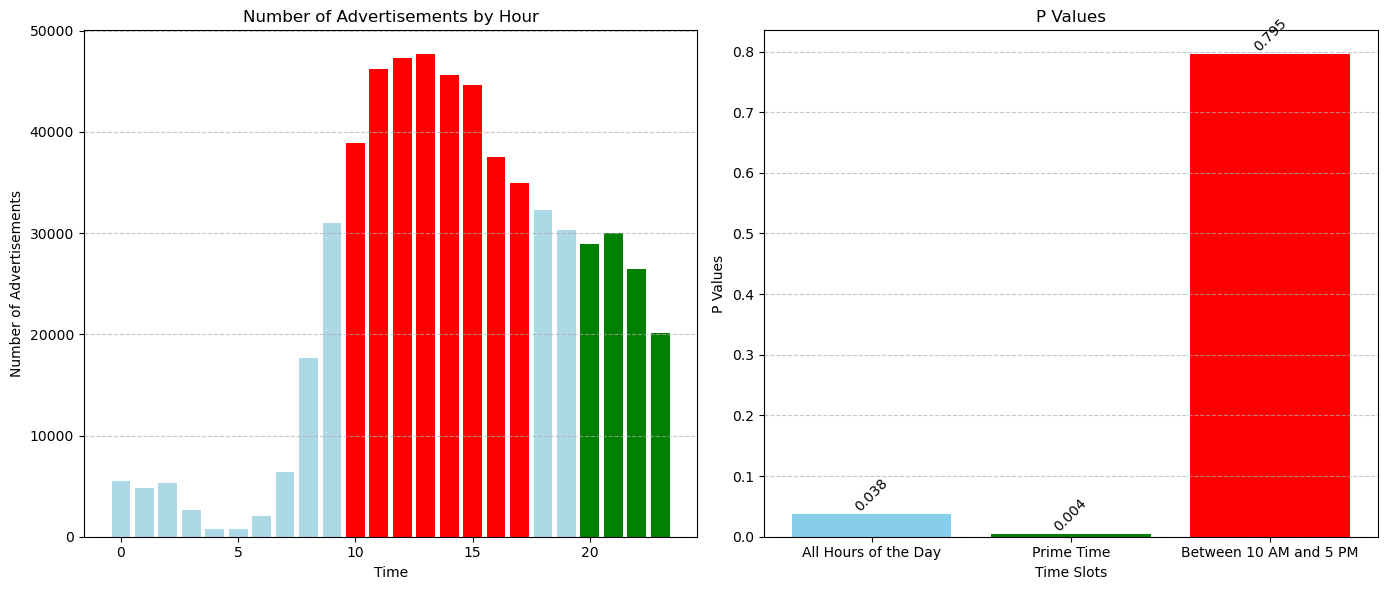

In [37]:
import matplotlib.pyplot as plt
import numpy as np

hour_counts = marketing['most ads hour'].value_counts().sort_index()
plt.figure(figsize=(14, 6))

colors = ['red' if 10 <= hour <= 17 else 'green' if 20 <= hour <= 23 else 'lightblue' for hour in hour_counts.index]

plt.subplot(1, 2, 1)
plt.bar(hour_counts.index, hour_counts.values, color=colors)
plt.xlabel('Time')
plt.ylabel('Number of Advertisements')
plt.title('Number of Advertisements by Hour')
plt.grid(axis='y', linestyle='--', alpha=0.7)

p_values = [0.03759017968909186, 0.004409116774006641, 0.7951472315657753]
p_labels = ['All Hours of the Day', 'Prime Time', 'Between 10 AM and 5 PM']

p_colors = ['skyblue', 'green', 'red']  # Test 3 için kırmızı renk

plt.subplot(1, 2, 2)
bars = plt.bar(p_labels, p_values, color=p_colors)

for bar, p_value in zip(bars, p_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{p_value:.3f}', ha='center', va='bottom', rotation=45)

plt.xlabel('Time Slots')
plt.ylabel('P Values')
plt.title('P Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Conclusion

*When analyzing advertisements between 10 AM and 5 PM, the null hypothesis (H0) is accepted, concluding that there is no significant difference.
*When examining the time data between 8 PM and 11 PM (prime time), a high level of significance (0.004) indicates that advertisements create significant changes with high accuracy, leading to the acceptance of the alternative hypothesis (H1).

Considering these findings, especially when the company is looking to save costs, it can be observed that there is potential for savings from advertisements aired between 10 AM and 5 PM.